In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../agent/cleaned_data/ETO.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,20.42,20.540001,20.370001,20.510000,10.236064,62800
1,1/3/2013,20.57,20.680000,20.530001,20.590000,10.275994,54400
2,1/4/2013,20.65,20.750000,20.600000,20.690001,10.325897,109900
3,1/7/2013,20.74,20.740000,20.559999,20.680000,10.320910,136000
4,1/8/2013,20.68,20.709999,20.600000,20.610001,10.285966,69200


In [3]:
class Agent:

    LEARNING_RATE = 1e-4
    LAYER_SIZE = 256
    GAMMA = 0.9
    OUTPUT_SIZE = 3

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.X = tf.placeholder(tf.float32, (None, self.state_size))
        self.REWARDS = tf.placeholder(tf.float32, (None))
        self.ACTIONS = tf.placeholder(tf.int32, (None))
        feed_forward = tf.layers.dense(self.X, self.LAYER_SIZE, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, self.OUTPUT_SIZE, activation = tf.nn.softmax)
        input_y = tf.one_hot(self.ACTIONS, self.OUTPUT_SIZE)
        loglike = tf.log((input_y * (input_y - self.logits) + (1 - input_y) * (input_y + self.logits)) + 1)
        rewards = tf.tile(tf.reshape(self.REWARDS, (-1,1)), [1, self.OUTPUT_SIZE])
        self.cost = -tf.reduce_mean(loglike * (rewards + 1)) 
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def discount_rewards(self, r):
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add * self.GAMMA + r[t]
            discounted_r[t] = running_add
        return discounted_r
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.get_predicted_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            ep_history = []
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.get_predicted_action(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= close[t]
                
                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                ep_history.append([state,action,starting_money,next_state])
                state = next_state
            ep_history = np.array(ep_history)
            ep_history[:,2] = self.discount_rewards(ep_history[:,2])
            cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X:np.vstack(ep_history[:,0]),
                                                    self.REWARDS:ep_history[:,2],
                                                    self.ACTIONS:ep_history[:,1]})
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
agent = Agent(state_size = window_size,
             window_size = window_size,
             trend = close,
             skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\Users\Magda\anaconda3\lib\site-packages\ipykernel_launcher.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


epoch: 10, total rewards: -1.120020.3, cost: -34892.570312, total money: 9998.879980
epoch: 20, total rewards: 0.529997.3, cost: -35001.425781, total money: 10000.529997
epoch: 30, total rewards: -29.210007.3, cost: -34212.863281, total money: 9764.049992
epoch: 40, total rewards: -53.290022.3, cost: -31764.285156, total money: 8221.359980
epoch: 50, total rewards: 5.549971.3, cost: -33059.164062, total money: 8941.679972
epoch: 60, total rewards: -24.000025.3, cost: -33982.281250, total money: 9665.719973
epoch: 70, total rewards: -15.590033.3, cost: -34485.148438, total money: 9959.109968
epoch: 80, total rewards: 9.139978.3, cost: -33394.878906, total money: 9017.119980
epoch: 90, total rewards: 12.149988.3, cost: -33221.289062, total money: 9256.919989
epoch: 100, total rewards: -6.030012.3, cost: -32952.816406, total money: 8833.859987
epoch: 110, total rewards: -31.029997.3, cost: -32905.070312, total money: 8783.570004
epoch: 120, total rewards: -26.199978.3, cost: -33251.531250

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 20.510000, total balance 9979.490000
day 1: buy 1 unit at price 20.590000, total balance 9958.900000
day 2: buy 1 unit at price 20.690001, total balance 9938.209999
day 4: buy 1 unit at price 20.610001, total balance 9917.599998
day 5, sell 1 unit at price 20.840000, investment 1.608971 %, total balance 9938.439999,
day 7: buy 1 unit at price 21.049999, total balance 9917.389999
day 10, sell 1 unit at price 21.110001, investment 2.525500 %, total balance 9938.500000,
day 11: buy 1 unit at price 21.379999, total balance 9917.120001
day 12: buy 1 unit at price 21.780001, total balance 9895.340000
day 14, sell 1 unit at price 21.750000, investment 5.123245 %, total balance 9917.090000,
day 16, sell 1 unit at price 21.969999, investment 6.598732 %, total balance 9939.059999,
day 18, sell 1 unit at price 22.020000, investment 4.608082 %, total balance 9961.080000,
day 21, sell 1 unit at price 22.110001, investment 3.414413 %, total balance 9983.190001,
day 22, sel

day 301, sell 1 unit at price 24.040001, investment -1.069952 %, total balance 10006.900005,
day 302: buy 1 unit at price 24.080000, total balance 9982.820005
day 304: buy 1 unit at price 24.100000, total balance 9958.720005
day 305, sell 1 unit at price 23.950001, investment -0.539864 %, total balance 9982.670006,
day 306: buy 1 unit at price 23.959999, total balance 9958.710007
day 309, sell 1 unit at price 24.049999, investment -0.207474 %, total balance 9982.760006,
day 310: buy 1 unit at price 24.010000, total balance 9958.750006
day 312: buy 1 unit at price 24.200001, total balance 9934.550005
day 313: buy 1 unit at price 24.309999, total balance 9910.240005
day 315: buy 1 unit at price 24.100000, total balance 9886.140005
day 316, sell 1 unit at price 23.940001, investment -0.083466 %, total balance 9910.080006,
day 320, sell 1 unit at price 23.760000, investment -1.041233 %, total balance 9933.840006,
day 321, sell 1 unit at price 23.500000, investment -2.892565 %, total balanc

day 472, sell 1 unit at price 25.600000, investment 0.352803 %, total balance 9635.330015,
day 473, sell 1 unit at price 25.389999, investment -0.509409 %, total balance 9660.720015,
day 474, sell 1 unit at price 25.870001, investment 2.131863 %, total balance 9686.590015,
day 476, sell 1 unit at price 25.570000, investment 1.508532 %, total balance 9712.160015,
day 477: buy 1 unit at price 25.790001, total balance 9686.370014
day 478: buy 1 unit at price 26.170000, total balance 9660.200014
day 480, sell 1 unit at price 26.330000, investment 3.702247 %, total balance 9686.530014,
day 483, sell 1 unit at price 26.070000, investment 3.781842 %, total balance 9712.600014,
day 486, sell 1 unit at price 25.990000, investment 5.180092 %, total balance 9738.590013,
day 489: buy 1 unit at price 25.260000, total balance 9713.330013
day 490, sell 1 unit at price 25.389999, investment 4.701028 %, total balance 9738.720013,
day 493, sell 1 unit at price 24.950001, investment 4.001672 %, total bal

day 779, sell 1 unit at price 19.559999, investment 5.786910 %, total balance 9755.040029,
day 780, sell 1 unit at price 19.150000, investment -0.260423 %, total balance 9774.190029,
day 782: buy 1 unit at price 18.330000, total balance 9755.860029
day 783, sell 1 unit at price 18.240000, investment -6.221085 %, total balance 9774.100029,
day 784, sell 1 unit at price 18.480000, investment -3.649639 %, total balance 9792.580029,
day 785: buy 1 unit at price 18.780001, total balance 9773.800028
day 786, sell 1 unit at price 19.389999, investment 0.466322 %, total balance 9793.190027,
day 788: buy 1 unit at price 19.160000, total balance 9774.030027
day 789, sell 1 unit at price 19.450001, investment -2.652647 %, total balance 9793.480028,
day 791, sell 1 unit at price 19.379999, investment -1.524396 %, total balance 9812.860027,
day 793: buy 1 unit at price 19.870001, total balance 9792.990026
day 794, sell 1 unit at price 19.809999, investment 0.000000 %, total balance 9812.800026,
day

day 957: buy 1 unit at price 21.280001, total balance 9555.930023
day 958: buy 1 unit at price 20.879999, total balance 9535.050024
day 959, sell 1 unit at price 21.120001, investment -4.864864 %, total balance 9556.170025,
day 960: buy 1 unit at price 21.139999, total balance 9535.030025
day 962: buy 1 unit at price 21.030001, total balance 9514.000025
day 966: buy 1 unit at price 20.570000, total balance 9493.430025
day 967, sell 1 unit at price 20.330000, investment -8.874942 %, total balance 9513.760025,
day 972: buy 1 unit at price 20.459999, total balance 9493.300026
day 973, sell 1 unit at price 20.549999, investment -7.971342 %, total balance 9513.850025,
day 974: buy 1 unit at price 20.389999, total balance 9493.460026
day 975: buy 1 unit at price 20.100000, total balance 9473.360025
day 978: buy 1 unit at price 20.209999, total balance 9453.150026
day 981: buy 1 unit at price 20.139999, total balance 9433.010027
day 982: buy 1 unit at price 20.100000, total balance 9412.91002

day 1136, sell 1 unit at price 24.570000, investment 7.105489 %, total balance 9487.210030,
day 1137, sell 1 unit at price 24.680000, investment 6.747402 %, total balance 9511.890030,
day 1140, sell 1 unit at price 25.469999, investment 8.985872 %, total balance 9537.360029,
day 1142, sell 1 unit at price 25.549999, investment 10.845987 %, total balance 9562.910028,
day 1143, sell 1 unit at price 25.830000, investment 12.012144 %, total balance 9588.740028,
day 1144, sell 1 unit at price 26.070000, investment 13.101955 %, total balance 9614.810028,
day 1145, sell 1 unit at price 25.889999, investment 11.546749 %, total balance 9640.700027,
day 1146, sell 1 unit at price 25.920000, investment 11.772313 %, total balance 9666.620028,
day 1147: buy 1 unit at price 25.510000, total balance 9641.110027
day 1148, sell 1 unit at price 25.490000, investment 7.326315 %, total balance 9666.600027,
day 1150, sell 1 unit at price 25.190001, investment 5.441612 %, total balance 9691.790028,
day 1151

day 1292: buy 1 unit at price 24.990000, total balance 9209.250019
day 1294: buy 1 unit at price 24.660000, total balance 9184.590019
day 1295, sell 1 unit at price 24.920000, investment -0.439475 %, total balance 9209.510019,
day 1296, sell 1 unit at price 25.120001, investment 0.439827 %, total balance 9234.630020,
day 1297, sell 1 unit at price 24.930000, investment 0.200969 %, total balance 9259.560020,
day 1298: buy 1 unit at price 24.660000, total balance 9234.900021
day 1299, sell 1 unit at price 24.389999, investment -1.851111 %, total balance 9259.290020,
day 1300, sell 1 unit at price 24.540001, investment -1.088265 %, total balance 9283.830021,
day 1302: buy 1 unit at price 24.889999, total balance 9258.940021
day 1303: buy 1 unit at price 24.889999, total balance 9234.050022
day 1304: buy 1 unit at price 25.160000, total balance 9208.890022
day 1305: buy 1 unit at price 25.980000, total balance 9182.910023
day 1307: buy 1 unit at price 25.410000, total balance 9157.500023
d

day 1445: buy 1 unit at price 25.280001, total balance 9214.610016
day 1446: buy 1 unit at price 25.320000, total balance 9189.290016
day 1449, sell 1 unit at price 25.030001, investment -4.209715 %, total balance 9214.320017,
day 1452, sell 1 unit at price 23.860001, investment -7.447634 %, total balance 9238.180017,
day 1453: buy 1 unit at price 23.709999, total balance 9214.470018
day 1454, sell 1 unit at price 23.090000, investment -8.879242 %, total balance 9237.560018,
day 1455, sell 1 unit at price 22.549999, investment -10.728428 %, total balance 9260.110018,
day 1456: buy 1 unit at price 22.780001, total balance 9237.330017
day 1457, sell 1 unit at price 23.290001, investment -7.395621 %, total balance 9260.620018,
day 1458: buy 1 unit at price 23.459999, total balance 9237.160019
day 1459: buy 1 unit at price 23.400000, total balance 9213.760019
day 1461, sell 1 unit at price 23.020000, investment -8.903838 %, total balance 9236.780020,
day 1462: buy 1 unit at price 22.850000

day 1615, sell 1 unit at price 22.270000, investment 28.062112 %, total balance 9120.800028,
day 1616: buy 1 unit at price 22.629999, total balance 9098.170029
day 1617, sell 1 unit at price 22.580000, investment 21.725072 %, total balance 9120.750029,
day 1619, sell 1 unit at price 23.309999, investment 14.601766 %, total balance 9144.060028,
day 1621, sell 1 unit at price 23.580000, investment 15.305619 %, total balance 9167.640028,
day 1622: buy 1 unit at price 23.650000, total balance 9143.990028
day 1623: buy 1 unit at price 23.639999, total balance 9120.350029
day 1625: buy 1 unit at price 24.049999, total balance 9096.300030
day 1626, sell 1 unit at price 24.049999, investment 17.031631 %, total balance 9120.350029,
day 1627: buy 1 unit at price 24.150000, total balance 9096.200029
day 1628: buy 1 unit at price 24.190001, total balance 9072.010029
day 1630, sell 1 unit at price 23.740000, investment 13.209349 %, total balance 9095.750029,
day 1631, sell 1 unit at price 23.870001

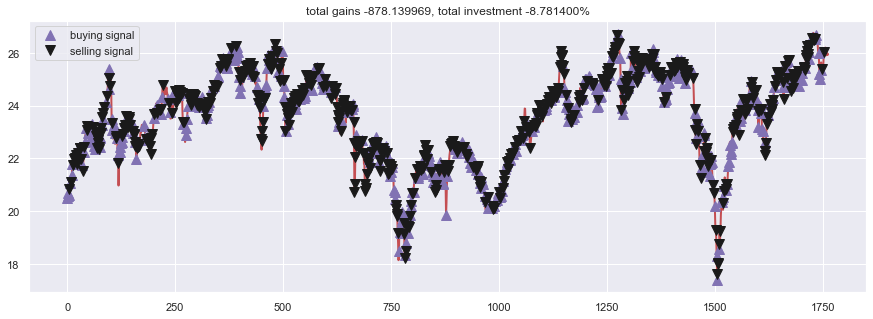

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()